# Nomalizing Flow with implicit coupling layers


In [1]:
#!pip install --quiet --upgrade pip
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
#!pip install --quiet --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.
#!pip install --quiet --upgrade dm-haiku optax tensorflow-probability jaxopt
#!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git@affine_sigmoid_bijecctor

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as onp
import haiku as hk
import optax
from functools import partial
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


2022-01-18 19:16:39.014587: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 19:16:39.119712: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 19:16:39.122257: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
d=2

In [4]:
from sbiexpt.distributions import get_two_moons
from sbiexpt.bijectors import MixtureAffineSigmoidBijector 

In [5]:
class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):

    # NN to get a b and c
    net = hk.Linear(256, name='l1')(x)
    net = jax.nn.silu(net) # silu = x*sigmoid(x)
    net = hk.Linear(256, name='l2')(net)
    net = jax.nn.silu(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    n_components = 60
   # n_components = 30
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_components, name='l3')(net)) * log_a_bound
    b   = hk.Linear(output_units*n_components, name='l4')(net)
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_components, name='l5')(net)) * (1 - min_density_lower_bound)
    p   = jax.nn.softmax(hk.Linear(n_components, name='l6')(net))
    return MixtureAffineSigmoidBijector(jnp.exp(log_a),b,c, p)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b2')),
            tfb.Permute([1,0])
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.Independent(tfd.TruncatedNormal(0.5*jnp.ones(d), 
                                                0.05*jnp.ones(d), 
                                                0.01,0.99),
                            reinterpreted_batch_ndims=1),
            bijector=chain)
        
      return nvp

In [6]:
model_NF = hk.without_apply_rng(hk.transform(lambda x : Flow()().log_prob(x)))
model_sample = hk.without_apply_rng(hk.transform(lambda nb_sample: Flow()().sample(nb_sample, seed=next(rng_seq))))

In [7]:
# This the loss by NLL
def loss_nll(params, batch, score):
    log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
    return -jnp.mean(log_prob)

# This is the loss for score matching
def loss_score(params, batch, score):
    log_prob, out = jax.vmap(jax.value_and_grad(lambda x, p: model_NF.apply(p, x.reshape([1,2])).squeeze()), [0, None])(batch, params) # Here we extract the grad of the model
    return jnp.mean(jnp.sum((out - score)**2, axis=1)) 

def loss_fn(params, batch, score, weight):
    log_prob, out = jax.vmap(jax.value_and_grad(lambda x, p: model_NF.apply(p, x.reshape([1,2])).squeeze()), [0, None])(batch, params) # Here we extract the grad of the model
    return  - jnp.mean(log_prob)  + jnp.mean(jnp.sum((out - score)**2, axis=1)) * weight

In [8]:
@jax.jit
def update(params, opt_state, batch, score, weight):
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score, weight)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [9]:
# DKL
def kl_divergence_fn(params, distribution_b, precision):      
  z = model_sample.apply(params, precision)        
  return jnp.mean(jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(z) - distribution_b.log_prob(z))

In [10]:
# MMD 
sigma = 1

def gaussian_kernel(x, y, sigma): 
  dif = np.tile(x, (1,len(x))).reshape(len(x),len(x),2) - np.tile(y, (len(y),1)).reshape(len(y),len(y),2)
  dif = jnp.linalg.norm(dif.reshape(-1,2), axis = 1).reshape(len(x),len(x))
  return jnp.exp( - dif**2 / (2*sigma**2))

 
def MMD(x, y, sigma):

    n = np.size(x)
    nn = n*n

    xx = gaussian_kernel(x, x, sigma)
    xx = jnp.sum(xx) - jnp.sum(jnp.diag(xx))

    yy = gaussian_kernel(y, y, sigma)
    yy = jnp.sum(yy) - jnp.sum(jnp.diag(yy))

    xy = jnp.sum(gaussian_kernel(x, y, sigma))

    return 1/(nn-n) * xx - 2/nn * xy + 1/(nn-n) * yy

In [11]:
# Negative log prob 
def neg_log_prob(observation, params):
  return - jnp.mean(jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(observation))

In [12]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier

def c2st(X,Y,seed,n_folds=5,scoring="accuracy",z_score=True,noise_scale=None):

  if z_score==True:
    X_mean = np.mean(X, axis = 0)
    X_std = np.std(X, axis = 0)
    X = (X - X_mean) / X_std
    Y = (Y - X_mean) / X_std

  if noise_scale is not None:
    X += noise_scale * np.random.rand(X.shape)
    Y += noise_scale * np.random.rand(Y.shape)
  
  clf = MLPClassifier(activation="relu",
                      hidden_layer_sizes=(500, 500),
                      max_iter=10000,
                      solver="adam",
                      random_state=seed,
                      )

  X = X.reshape(-1,1)
  Y = Y.reshape(-1,1)
  data = np.concatenate((X,Y))
  target = np.concatenate((np.zeros(len(X)),np.ones(len(Y))))


  shuffle = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
  scores = cross_val_score(clf, data, target.ravel(), cv=shuffle, scoring=scoring)

  return np.mean(scores)

In [13]:
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=1000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))


In [14]:
x = jnp.stack(jnp.meshgrid(jnp.linspace(0.,1.,128),
                           jnp.linspace(0.,1.,128)),-1)

2022-01-18 19:16:40.660777: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-18 19:16:40.660874: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
!mkdir contour_png

mkdir: cannot create directory ‘contour_png’: File exists


In [16]:
precision = 1000

In [17]:
save_dkl = []
save_mmd = []
save_neg_log_prob = []
save_c2st = []
savecontour = []

In [18]:
dif_size = jnp.array([10,30,50,70,90])

____batch_size : 10


100%|███████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:09<00:00, 30.91it/s]


____batch_size : 30


100%|███████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:27<00:00, 27.18it/s]


____batch_size : 50


100%|███████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:47<00:00, 23.93it/s]


____batch_size : 70


100%|███████████████████████████████████████████████████████████████████████████████| 4000/4000 [03:03<00:00, 21.78it/s]


____batch_size : 90


100%|███████████████████████████████████████████████████████████████████████████████| 4000/4000 [02:38<00:00, 25.18it/s]


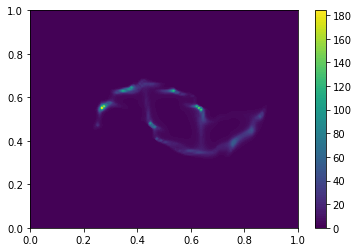

In [19]:
save_dkl = []
save_mmd = []
save_neg_log_prob = []
save_c2st = []
savecontour = []

losses = ['nll+score', 'nll']

i = 0
for batch_size in dif_size:
  print('____batch_size :', batch_size)
  save_dkl.append([])
  save_mmd.append([])
  save_neg_log_prob.append([])
  save_c2st.append([])

  @jax.jit
  def get_batch(seed):
    two_moons = get_two_moons(sigma = 0.01, normalized=True)
    batch = two_moons.sample(batch_size, seed=seed)
    score = jax.vmap(jax.grad(two_moons.log_prob))(batch)
    return batch, score

  batch, score_batch = get_batch(jax.random.PRNGKey(0))
  for weight in [1e-3, 0]:
    
    params = 0
    rng_seq = hk.PRNGSequence(12)
    params = model_NF.init(next(rng_seq), 0.5*jnp.ones([1,d]))
    opt_state = optimizer.init(params)
#4000

    
    for step in tqdm(range(4000)):
      inds = np.random.randint(0, batch_size, int(batch_size / 2))
      l, params, opt_state = update(params, opt_state, batch[inds], score_batch[inds], weight)
      if jnp.isnan(l) == True :
        print('nop')
        break

    plt.clf()
    im0 = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(x.reshape([-1,2])).reshape([128,128])
    contourf(x[...,0],x[...,1],jnp.exp(im0), 100); colorbar()
    plt.savefig("/home/juz/contour_png/{batch_size}W{weight}.png".format(batch_size = batch_size, weight = weight))
    plt.savefig("/home/juz/contour_png/{batch_size}W{weight}.pdf".format(batch_size = batch_size, weight = weight))
    savecontour.append("/home/juz/contour_png/{batch_size}W{weight}.png".format(batch_size = batch_size, weight = weight))
    jnp.save("/home/juz/contour_png/batchsize_{batch_size}_Weight_{weight}.npy".format(batch_size = batch_size, weight = weight), im0)


    save_dkl[i].append(kl_divergence_fn(params, 
                                        get_two_moons(sigma = 0.01, normalized=True), 
                                        precision))
    
    save_mmd[i].append(MMD(model_sample.apply(params, precision), 
                           get_two_moons( sigma = 0.01, normalized=True).sample(precision, jax.random.PRNGKey(10)), 
                           1))
    
    save_neg_log_prob[i].append(neg_log_prob(get_two_moons(sigma = 0.01, normalized=True).sample(precision, jax.random.PRNGKey(10)), params))
   
    save_c2st[i].append(c2st(model_sample.apply(params, precision),
                              get_two_moons( sigma = 0.01, normalized=True).sample(precision, jax.random.PRNGKey(10)), 
                              1,
                              n_folds=5,
                              scoring="accuracy",
                              z_score=True,
                              noise_scale=None))
  i +=1

In [20]:
losses = ['nll+score', 'nll']

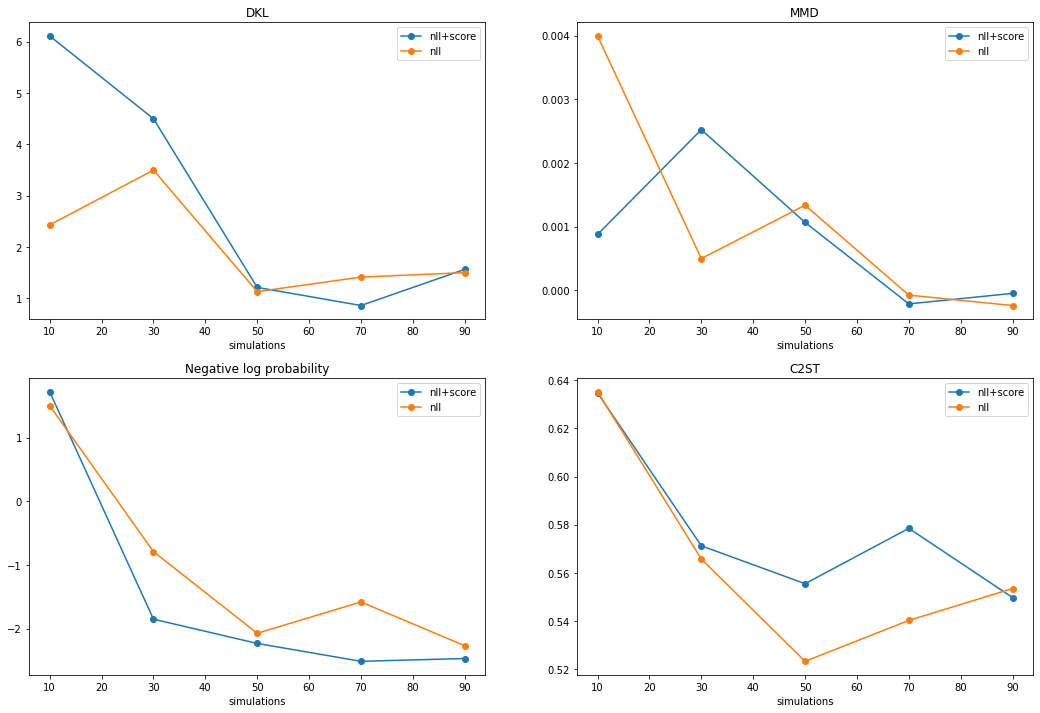

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize= (18,12))
it = 0
for j in range(2):
  ax1.plot(dif_size, jnp.array(save_dkl).T[j], label = "{j}".format(j=losses[j]), marker = 'o')
  ax1.legend()
  ax1.set(xlabel ='simulations')
  ax1.set_title('DKL')
  ax2.plot(dif_size, jnp.array(save_mmd).T[j], label = "{j}".format(j=losses[j]), marker = 'o')
  ax2.legend()
  ax2.set(xlabel ='simulations')
  ax2.set_title('MMD')
  ax3.plot(dif_size, jnp.array(save_neg_log_prob).T[j], label = "{j}".format(j=losses[j]), marker = 'o')
  ax3.legend()
  ax3.set(xlabel ='simulations')
  ax3.set_title('Negative log probability')
  ax4.plot(dif_size, jnp.array(save_c2st).T[j], label = "{j}".format(j=losses[j]), marker = 'o')
  ax4.legend()
  ax4.set(xlabel ='simulations')
  ax4.set_title('C2ST')
    
plt.savefig("/home/juz/contour_png/metrics.png")

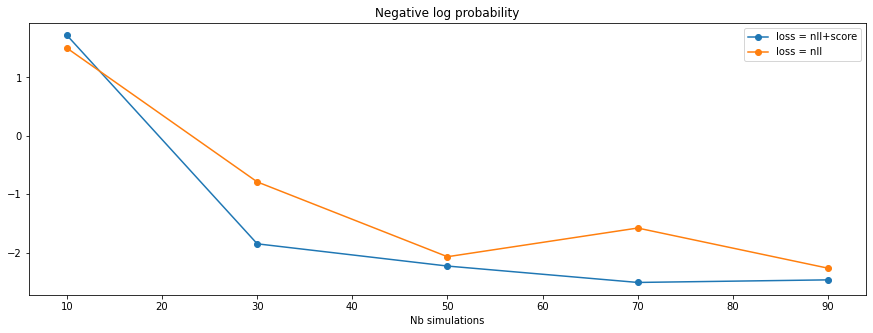

In [22]:
plt.figure(figsize= (15,5))
it = 0
for j in range(2):
    plt.plot(dif_size, jnp.array(save_neg_log_prob).T[j], label = "loss = {j}".format(j=losses[j]), marker = 'o')
    plt.legend()
    plt.xlabel('Nb simulations')
    plt.title('Negative log probability')
    
plt.savefig("/home/juz/contour_png/metrics.pdf")

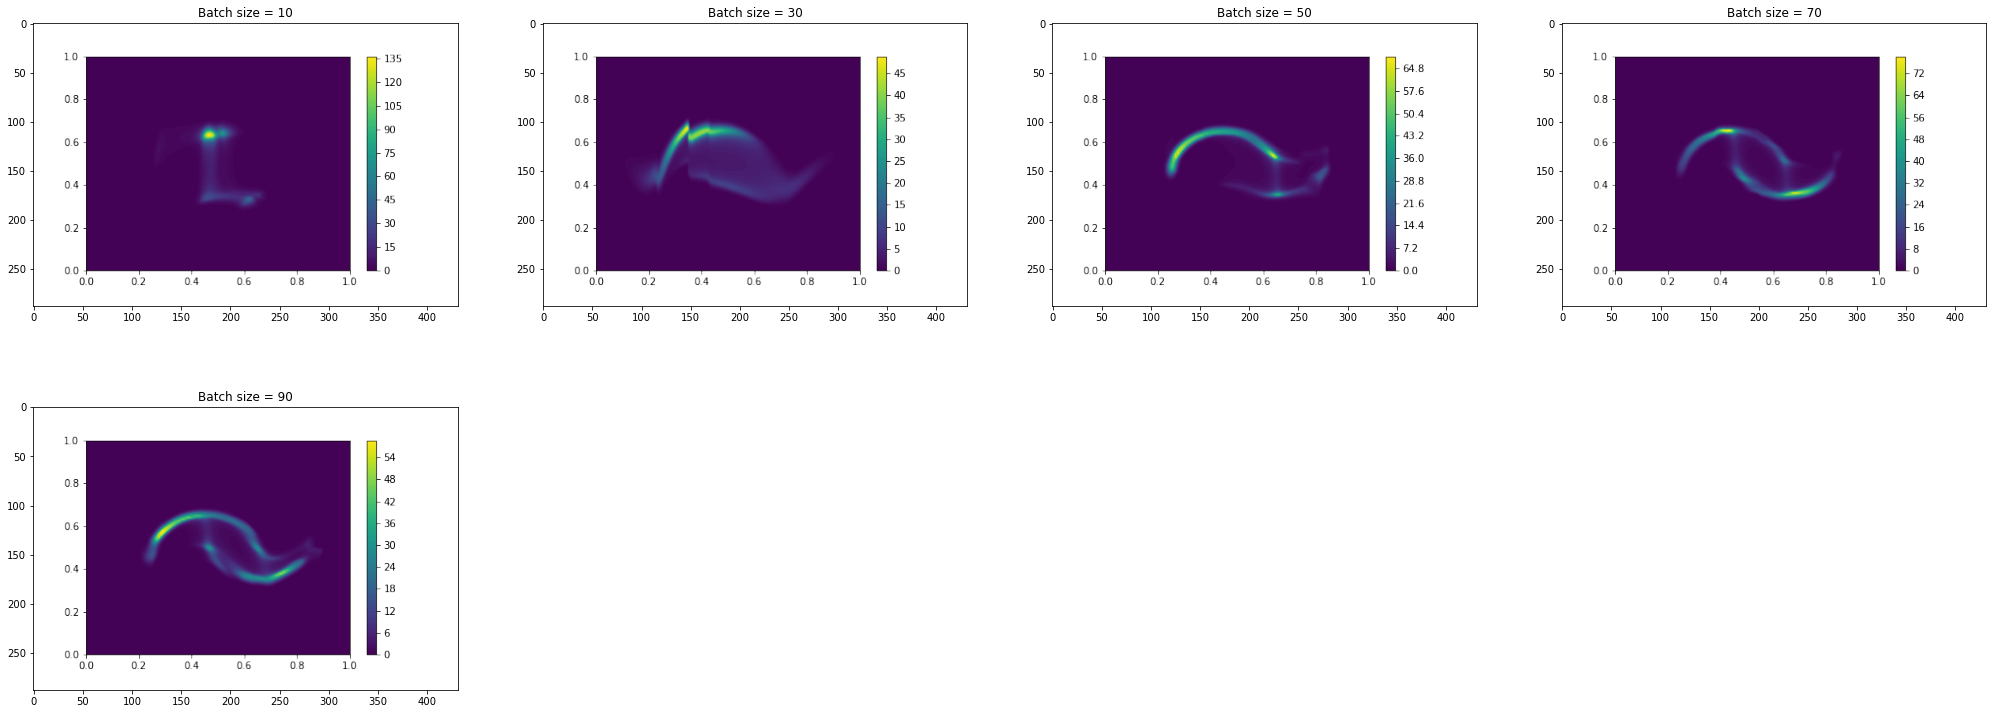

In [23]:
import matplotlib.image as mpimg
plt.figure(figsize = (35,20))
bs = dif_size
it = 0
for i in savecontour[0::2] :

    it +=1
    plt.subplot(3, 4, it)
    img = mpimg.imread(i)
    plt.imshow(img)
    plt.title("Batch size = {it}".format(it = bs[it-1]))
        
plt.savefig("/home/juz/contour_png/znll.png")

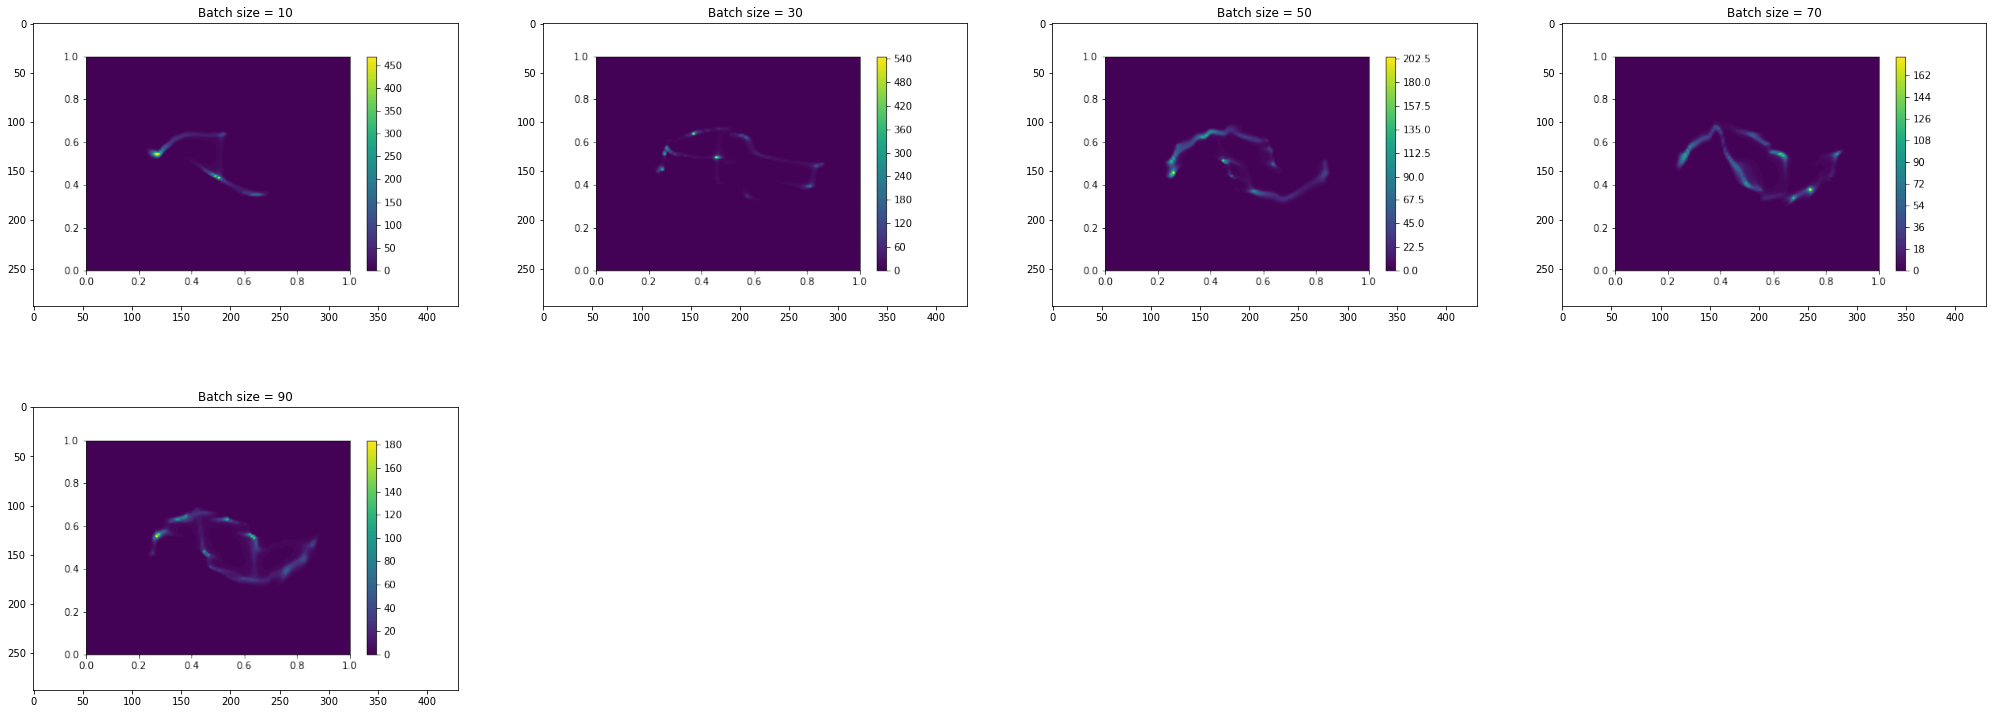

In [24]:
import matplotlib.image as mpimg
plt.figure(figsize = (35,20))
bs = dif_size
it = 0
for i in savecontour[1::2] :

    it +=1
    plt.subplot(3, 4, it)
    img = mpimg.imread(i)
    plt.imshow(img)
    plt.title("Batch size = {it}".format(it = bs[it-1]))

plt.savefig("/home/juz/contour_png/znllscore.png")   

In [25]:
#import tensorflow as tf
#tf.compat.v1.gfile.DeleteRecursively('/content/contour_png')